## Getting Started

In [1]:
%%capture

!pip install unsloth

## Loading `Llama-3.2-11B-Vision-Instruct` Model

In [2]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.8: Fast Mllama vision patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

## Setting Up the LoRA

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, 
    finetune_language_layers   = True, 
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,           
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3443,
    use_rslora = False,
    loftq_config = None,
)

## Loading the Dataset

In [4]:
from datasets import load_dataset
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm", 
                       split = "train[0:500]")

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description'],
    num_rows: 500
})

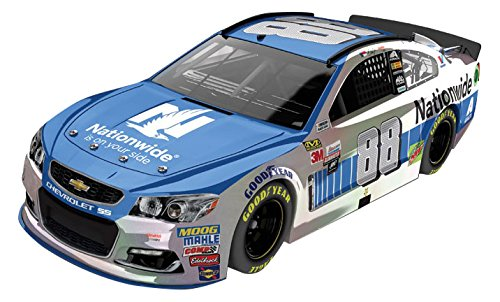

In [6]:
dataset[45]["image"]

In [7]:
dataset[45]["description"]

'Authentic Dale Earnhardt Jr. 1:24 scale diecast car. Nationwide Raw Finish.  Collectible model car for racing fans.  Perfect gift for NASCAR enthusiasts.'

## Processing the Dataset

In [8]:
instruction = """
You are an expert Amazon worker who is good at writing product descriptions. 
Write the product description accurately by looking at the image.
"""


def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["description"]}],
        },
    ]
    return {"messages": conversation}


pass


In [9]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [10]:
converted_dataset[45]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\nYou are an expert Amazon worker who is good at writing product descriptions. \nWrite the product description accurately by looking at the image.\n'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x302>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Authentic Dale Earnhardt Jr. 1:24 scale diecast car. Nationwide Raw Finish.  Collectible model car for racing fans.  Perfect gift for NASCAR enthusiasts.'}]}]}

## Model Inference Before Fine-tuning

In [11]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)


The image showcases a race car featuring the well-known sponsorship branding "Nationwide," likely the primary vehicle in the Nationwide Series. The vehicle has a blue hood with the "Nationwide" logo prominently displayed and white text that reads, "on your side," on the windscreen. The car is predominantly white and grey, adorned with sponsor decals on various parts of the vehicle.

The front grille showcases the Chevrolet "Bowtie" logo, denoted as "SS," indicating that it is the Chevrolet SS model. Additionally, the car is emblazoned with the number 88 in white, which is likely the race car's primary number


## Setting Up Model for Fine-tuning

In [12]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)


max_steps is given, it will override any value given in num_train_epochs


In [13]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
9.068 GB of memory reserved.


## Training the Model

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
5,3.203200
10,2.088400
15,1.333400
20,1.176300
25,1.084700
30,1.100800


In [15]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1026.4487 seconds used for training.
17.11 minutes used for training.
Peak reserved memory = 10.682 GB.
Peak reserved memory for training = 1.614 GB.
Peak reserved memory % of max memory = 72.465 %.
Peak reserved memory for training % of max memory = 10.949 %.


## Model Inference After Fine-tuning

In [16]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)


Bring the thrill of NASCAR racing to your desk or shelf with the 1/64 Die-Cast 2016 NASCAR 88 Dale Earnhardt Jr. Nationwide Chevrolet SS!  Highly detailed and precision engineered, this collectible die-cast car captures the iconic look of Earnhardt's famous No. 88 ride. Perfect for kids and adults alike, this miniature masterpiece makes a great gift. #NASCAR #DieCast #CollectibleCars #DaleEarnhardtJr #Nationwide<|eot_id|>


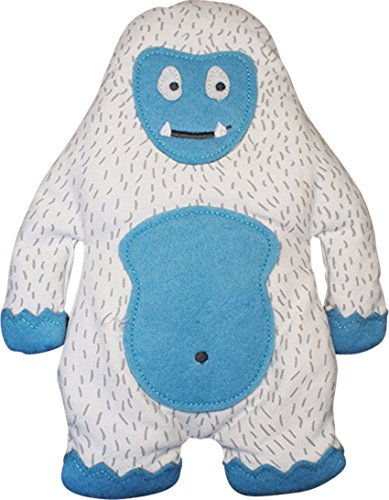

In [17]:
dataset[60]["image"]

In [18]:
image = dataset[60]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

Charming Little Friends Felt Yeti Doll: This adorable hand-stitched doll is perfect for imaginative play.  Soft, colorful felt construction brings the yeti to life.  A sweet gift or addition to your little one's playtime.  Handmade with care.<|eot_id|>


## Saving the Adopter, Model, and Tokenizer

In [19]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(hf_token)

In [20]:
model.save_pretrained("llama_3.2_vision_amazon_product") # Local saving
tokenizer.save_pretrained("llama_3.2_vision_amazon_product")


[]

In [21]:
model.push_to_hub(
    "kingabzpro/llama_3.2_vision_amazon_product"
)  # Online saving
tokenizer.push_to_hub(
    "kingabzpro/llama_3.2_vision_amazon_product"
)  # Online saving

README.md:   0%|          | 0.00/633 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Saved model to https://huggingface.co/kingabzpro/llama_3.2_vision_amazon_product


No files have been modified since last commit. Skipping to prevent empty commit.
